In [6]:
# fetch_topology.py
import topohub, networkx as nx

# Examples of IDs: 'topozoo/Abilene', 'sndlib/Polska' or 'gabriel/25/0'
# Use topohub.get to fetch a topology dict; TopoHub mirrors Topology Zoo and SNDlib.
TOPO_ID = 'topozoo/Abilene'   # change as desired

topo = topohub.get(TOPO_ID)
G = nx.node_link_graph(topo)   # NetworkX graph with attributes
print("Loaded topology:", topo.get('name', TOPO_ID))
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))
# Inspect edge attributes: e.g., G.edges[data=True]
# Save graph for subsequent scripts
import pickle
pickle.dump(G, open("topo_graph.pkl","wb"))


Loaded topology: topozoo/Abilene
Nodes: 11 Edges: 14


In [7]:
# classical_pipeline.py
import pickle, networkx as nx, itertools
from heapq import nsmallest
import pulp, math

G = pickle.load(open("topo_graph.pkl","rb"))

In [8]:
# 1) Normalize / ensure required edge attributes
# If dataset lacks capacity/latency/energy, set defaults:
for u,v,data in G.edges(data=True):
    if 'cap' not in data: data['cap'] = 1000  # Mbps default (tune per topology)
    if 'lat' not in data: data['lat'] = int(data.get('dist',10))  # ms, use 'dist' if available
    if 'energy_per_mbps' not in data: data['energy_per_mbps'] = 0.02  # W per Mbps default


In [9]:
    # 2) Load or synthesize demand matrix
    # If dataset includes 'demands' use it; else synthesize random demands
    demands = topo.get('demands', None) if 'topo' in globals() else None
    if demands is None:
        import random
        random.seed(0)
        demands = []
        nodes = list(G.nodes())
        for i in range(40):  # adjustable
            s,t = random.sample(nodes, 2)
            bw = random.choice([10,20,50,100,200])  # Mbps
            sla = random.choice([30,50,80,120])
            demands.append({'id':f'D{i+1}','src':s,'dst':t,'bw':bw,'sla':sla})


In [10]:
# 3) Candidate paths per demand (k-shortest by latency)
def k_shortest_paths(G, source, target, k=4, weight='lat'):
    # simple Yen's algorithm with networkx if available
    try:
        from networkx.algorithms.simple_paths import shortest_simple_paths
        paths = []
        gen = shortest_simple_paths(G, source, target, weight=weight)
        for _, p in zip(range(k), gen):
            # compute total latency
            lat = sum(G[p[i]][p[i+1]].get('lat',0) for i in range(len(p)-1))
            paths.append({'nodes':p, 'lat':lat})
        return paths
    except Exception:
        # fallback BFS limited depth
        return []

In [11]:
K = 3
P = {}
for d in demands:
    pths = k_shortest_paths(G, d['src'], d['dst'], k=K)
    # Filter SLA-violating paths
    pths = [p for p in pths if p['lat'] <= d['sla']]
    if not pths:
        # if none, take unconstrained shortest path
        try:
            p = nx.shortest_path(G, d['src'], d['dst'], weight='lat')
            lat = sum(G[p[i]][p[i+1]].get('lat',0) for i in range(len(p)-1))
            pths = [{'nodes':p,'lat':lat}]
        except nx.NetworkXNoPath:
            pths=[]
    P[d['id']] = pths

# 4) ILP formulation with drop option (patched)
# ----- PATCH START -----
import pulp

empty = [d['id'] for d in demands if len(P[d['id']]) == 0]
if empty:
    print("Demands with ZERO candidate paths (violating SLA):", empty)
    print("Adding a 'drop' option so the ILP stays feasible.")

x = {}
z = {}
for d in demands:
    for idx, p in enumerate(P[d['id']]):
        x[(d['id'], idx)] = pulp.LpVariable(f"x_{d['id']}_{idx}", cat='Binary')
    z[d['id']] = pulp.LpVariable(f"drop_{d['id']}", cat='Binary')

def path_energy(G, nodes, bw):
    return sum(G[nodes[i]][nodes[i+1]]['energy_per_mbps'] * bw for i in range(len(nodes)-1))

DROP_PENALTY = 1e6
objective_terms = []
for d in demands:
    for idx in range(len(P[d['id']])):
        objective_terms.append(path_energy(G, P[d['id']][idx]['nodes'], d['bw']) * x[(d['id'], idx)])
    objective_terms.append(DROP_PENALTY * z[d['id']])

prob = pulp.LpProblem("EnergyAwareRouting", pulp.LpMinimize)
prob += pulp.lpSum(objective_terms)

for d in demands:
    prob += pulp.lpSum([x[(d['id'], idx)] for idx in range(len(P[d['id']]))]) + z[d['id']] == 1

for u, v, data in G.edges(data=True):
    prob += pulp.lpSum([
        d['bw'] * x[(d['id'], idx)]
        for d in demands for idx in range(len(P[d['id']]))
        if any((a == u and b == v) or (a == v and b == u)
               for a, b in zip(P[d['id']][idx]['nodes'][:-1], P[d['id']][idx]['nodes'][1:]))
    ]) <= data['cap']

cbc_path = "/opt/homebrew/opt/cbc/bin/cbc" 
prob.solve(pulp.COIN_CMD(path=cbc_path, msg=True, timeLimit=60))
print("Solver status:", pulp.LpStatus[prob.status])

sol = {}
total_energy = 0.0
dropped = []
for d in demands:
    if pulp.value(z[d['id']]) and pulp.value(z[d['id']]) > 0.5:
        dropped.append(d['id'])
        continue
    for idx in range(len(P[d['id']])):
        if pulp.value(x[(d['id'], idx)]) > 0.5:
            sol[d['id']] = idx
            total_energy += path_energy(G, P[d['id']][idx]['nodes'], d['bw'])
            break

def link_utilization(G, sol):
    util = {(u, v): 0.0 for u, v in G.edges()}
    for d in demands:
        idx = sol.get(d['id'])
        if idx is None:
            continue
        nodes = P[d['id']][idx]['nodes']
        for a, b in zip(nodes[:-1], nodes[1:]):
            e = (a, b) if (a, b) in util else (b, a)
            util[e] += d['bw']
    util_pct = {e: 100.0 * load / G[e[0]][e[1]]['cap'] for e, load in util.items()}
    return util, util_pct

util_abs, util_pct = link_utilization(G, sol)
print(f"ILP result (with drop option): total energy = {total_energy:.3f}")
print(f"Dropped demands: {len(dropped)}")
print(f"Max link utilization: {max(util_pct.values()):.1f}%")
# ----- PATCH END -----


Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Aug 20 2024 

command line - /opt/homebrew/opt/cbc/bin/cbc /var/folders/c8/gcpq5wfj6vqf9rqk1jhxvqq80000gn/T/dfc17fa380a6474bbd81ebc7c3227cf0-pulp.mps -sec 60 -timeMode elapsed -branch -printingOptions all -solution /var/folders/c8/gcpq5wfj6vqf9rqk1jhxvqq80000gn/T/dfc17fa380a6474bbd81ebc7c3227cf0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 59 COLUMNS
At line 491 RHS
At line 546 BOUNDS
At line 627 ENDATA
Problem MODEL has 54 rows, 80 columns and 191 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.55012e+06 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 4 rows, 24 columns (24 integer (21 of which binary)) and 53 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.45
Cbc0038I Solution found of 3

In [12]:
import pickle

# After computing 'demands' and 'P' in classical code
with open("demands.pkl", "wb") as f:
    pickle.dump(demands, f)

with open("candidate_paths.pkl", "wb") as f:
    pickle.dump(P, f)

print("Saved demands and candidate paths for QAOA pipeline.")
import pickle

demands = pickle.load(open("demands.pkl", "rb"))
P = pickle.load(open("candidate_paths.pkl", "rb"))

# Check for ellipsis in demands
for d in demands:
    for k, v in d.items():
        if v is ...:
            print("Found ellipsis in demands:", d)

# Check for ellipsis in P
for k, paths in P.items():
    for p in paths:
        for kk, vv in p.items():
            if vv is ...:
                print("Found ellipsis in P:", k, p)

Saved demands and candidate paths for QAOA pipeline.


In [13]:
# qaoa_pipeline_small.py
import pickle
import numpy as np
from numbers import Number

# Qiskit imports
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp

# -------------------------------
# Load topology graph and classical outputs
# -------------------------------
G = pickle.load(open("topo_graph.pkl", "rb"))

# Fill missing edge attributes
for u, v, data in G.edges(data=True):
    if 'cap' not in data:
        data['cap'] = 1000  # Mbps
    if 'lat' not in data:
        data['lat'] = int(data.get('dist', 10))  # ms
    if 'energy_per_mbps' not in data:
        data['energy_per_mbps'] = 0.02  # W per Mbps

# Load classical outputs
demands_full = pickle.load(open("demands.pkl", "rb"))
P_full = pickle.load(open("candidate_paths.pkl", "rb"))

# -------------------------------
# Reduce problem size (limit qubits)
# -------------------------------
MAX_DEMANDS = 4     # pick first 4 demands
MAX_PATHS = 3       # pick first 3 paths per demand

demands = demands_full[:MAX_DEMANDS]
P = {}
for d in demands:
    P[d['id']] = P_full[d['id']][:MAX_PATHS]

# -------------------------------
# Build variable index mapping
# -------------------------------
var_index = {}
rev_var = {}
idx = 0
for d in demands:
    for p_idx in range(len(P[d['id']])):
        var_index[(d['id'], p_idx)] = idx
        rev_var[idx] = (d['id'], p_idx)
        idx += 1
nvars = idx
print(f"Reduced problem size: {nvars} variables (~{nvars} qubits)")

# -------------------------------
# Compute energy, edge incidence, latency
# -------------------------------
var_energy = np.zeros(nvars)
var_edge_incidence = [dict() for _ in range(nvars)]
var_latency = np.zeros(nvars)

for (did, pidx), v in var_index.items():
    d = next(x for x in demands if x['id'] == did)
    nodes = P[did][pidx]['nodes']
    lat = P[did][pidx]['lat']
    var_latency[v] = lat
    e_energy = 0.0
    inc = {}
    for i in range(len(nodes)-1):
        u, vv = nodes[i], nodes[i+1]
        ekey = (u, vv) if (u, vv) in G.edges else (vv, u)
        bw = d['bw']
        inc[ekey] = inc.get(ekey, 0) + bw
        e_energy += G[u][vv]['energy_per_mbps'] * bw
    var_energy[v] = e_energy
    var_edge_incidence[v] = inc

# -------------------------------
# Build QUBO dictionary
# -------------------------------
Q = {}
const = 0.0

# Linear energy terms
for i in range(nvars):
    Q[(i, i)] = Q.get((i, i), 0.0) + float(var_energy[i])

# One-hot constraints
penalty_A = 1e5
for d in demands:
    vars_d = [var_index[(d['id'], p)] for p in range(len(P[d['id']]))]
    for i in vars_d:
        Q[(i, i)] = Q.get((i, i), 0.0) + penalty_A
        for j in vars_d:
            if j <= i:
                continue
            Q[(i, j)] = Q.get((i, j), 0.0) + 2 * penalty_A
    const += penalty_A * 1

# Capacity penalties
penalty_B = 500.0
for u, v, edata in G.edges(data=True):
    cap = edata['cap']
    vars_aff = [i for i in range(nvars) if (u, v) in var_edge_incidence[i] or (v, u) in var_edge_incidence[i]]
    for i in vars_aff:
        bw_i = var_edge_incidence[i].get((u, v), 0) + var_edge_incidence[i].get((v, u), 0)
        Q[(i, i)] = Q.get((i, i), 0.0) + penalty_B*(bw_i**2) - 2*penalty_B*cap*bw_i
        for j in vars_aff:
            if j <= i:
                continue
            bw_j = var_edge_incidence[j].get((u, v), 0) + var_edge_incidence[j].get((v, u), 0)
            Q[(i, j)] = Q.get((i, j), 0.0) + 2*penalty_B*bw_i*bw_j
    const += penalty_B*(cap**2)

# SLA penalties
penalty_lat = 1e6
for i in range(nvars):
    did, pidx = rev_var[i]
    d = next(x for x in demands if x['id'] == did)
    if var_latency[i] > d['sla']:
        Q[(i, i)] = Q.get((i, i), 0.0) + penalty_lat

# -------------------------------
# Convert QUBO to Ising coefficients
# -------------------------------
def qubo_to_ising(Q, nvars):
    a = np.zeros(nvars)
    b = {}
    const = 0.0
    for (i, j), coeff in Q.items():
        coeff = float(coeff)
        if i == j:
            const += 0.5*coeff
            a[i] += -0.5*coeff
        else:
            const += 0.25*coeff
            a[i] += -0.25*coeff
            a[j] += -0.25*coeff
            b[(i, j)] = b.get((i, j), 0.0) + 0.25*coeff
    return a, b, const

a, b, const = qubo_to_ising(Q, nvars)

# -------------------------------
# Build PauliSumOp safely
# -------------------------------
pauli_list = []

for i in range(nvars):
    coeff = float(a[i])
    if abs(coeff) < 1e-12:
        continue
    label = ['I'] * nvars
    label[nvars-1-i] = 'Z'
    pauli_list.append((''.join(label), coeff))

for (i, j), c in b.items():
    coeff = float(c)
    if abs(coeff) < 1e-12:
        continue
    label = ['I'] * nvars
    label[nvars-1-i] = 'Z'
    label[nvars-1-j] = 'Z'
    pauli_list.append((''.join(label), coeff))

# Safety check
if len(pauli_list) == 0:
    pauli_list.append(('I'*nvars, 0.0))

H = PauliSumOp.from_list(pauli_list)

# -------------------------------
# Run QAOA
# -------------------------------
qi = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)
qaoa = QAOA(optimizer=COBYLA(maxiter=100), reps=2, quantum_instance=qi)

res = qaoa.compute_minimum_eigenvalue(operator=H)

print("QAOA result:", res)
print("QUBO constant term:", const)

Reduced problem size: 4 variables (~4 qubits)
QAOA result: {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 46,
    'eigenstate': {   '0000': 0.44633927678392815,
                      '0001': 0.3549317716125171,
                      '0010': 0.1795175827043134,
                      '0011': 0.13621559198564606,
                      '0100': 0.42274216432714634,
                      '0101': 0.37238672774415577,
                      '0110': 0.125,
                      '0111': 0.14657549249448218,
                      '1000': 0.2614562582918986,
                      '1001': 0.2096313728906053,
                      '1010': 0.06987712429686843,
                      '1011': 0.08838834764831845,
                      '1100': 0.25,
                      '1101': 0.24206145913796356,
                      '1110': 0.11692679333668567,
                      '1111': 0.09882117688026186},
    'eigenvalue': (50590330.97265626+0j),
    'optimal_circuit': None,
    'optimal_para

In [18]:
def print_solution_details(solution, demands, P, G):
    print("Demand -> chosen path (index): nodes, bw, latency")
    capacity_usage = {(u,v):0 for u,v in G.edges()}
    total_energy = 0.0
    for i, pidx in enumerate(solution):
        d = demands[i]
        if pidx == -1:
            print(f"{d['id']}: DROPPED")
            continue
        path = P[d['id']][pidx]['nodes']
        lat = P[d['id']][pidx]['lat']
        print(f"{d['id']}: path {pidx} nodes={path}, bw={d['bw']}, lat={lat}")
        for a,b in zip(path[:-1], path[1:]):
            e = (a,b) if (a,b) in capacity_usage else (b,a)
            capacity_usage[e] += d['bw']
            total_energy += G[a][b]['energy_per_mbps'] * d['bw']
    print("\nPer-link usage (used / cap, fraction):")
    for e, used in capacity_usage.items():
        cap = G[e[0]][e[1]]['cap']
        print(f"{e}: {used}/{cap} -> {used/cap:.3f}")
    print(f"\nTotal energy (sum over edges): {total_energy}")

In [24]:
# unified_pipeline_multi_topos.py
"""
Unified pipeline for running ILP, GA and ACO across multiple topologies.
- Generates realistic demands (SLA relative to shortest-path latency)
- Computes k-shortest candidate paths
- Allows toggle: fallback path if no SLA-satisfying path exists
- Evaluates solutions using energy + capacity penalties + variance (load-balancing)
- Saves demands & candidate paths for later QUBO experiments
"""

import os, pickle, json, random, math
from statistics import variance
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import pulp

# -------------------------------
# User parameters (tune these)
# -------------------------------
TOPO_IDS = [
    # examples; replace or extend as needed. If topohub not available,
    # you can place a local topo_graph.pkl and use load_local = True below.
    "topozoo/Abilene",
    "sndlib/Polska",
    # "gabriel/25/0",
]
USE_TOPOHUB = True          # if False, script expects topo_graph.pkl in working dir
OUTPUT_DIR = "pipeline_outputs"
DEMAND_COUNT = 20           # number of demands to synthesize (reduce for quick runs)
K_PATHS = 5                 # k-shortest candidate paths to compute
ALLOW_FALLBACK_PATH = False # if True, always ensure >=1 path per demand (fallback to shortest)
RNG_SEED = 0

# Evaluation weights
DROP_PENALTY = 1e6
CAPACITY_PENALTY_WEIGHT = 500.0   # squared overflow weight
VARIANCE_WEIGHT = 1000.0          # how much to penalize variance across links

# QUBO selection helper
QUANTUM_DEMANDS = 6    # when preparing QUBO, pick a subset of this many demands
MAX_PATHS_PER_DEMAND = 3

os.makedirs(OUTPUT_DIR, exist_ok=True)
random.seed(RNG_SEED)


# -------------------------------
# Helper: load topology (topohub or local)
# -------------------------------
def load_topology(topo_id=None, local_file=None):
    if local_file and os.path.exists(local_file):
        return pickle.load(open(local_file, "rb"))
    if not topo_id:
        raise ValueError("Provide topo_id or local_file")
    if not USE_TOPOHUB:
        raise RuntimeError("TopoHub disabled; provide local_file")
    try:
        import topohub
        topo = topohub.get(topo_id)
        G = nx.node_link_graph(topo)
        return G
    except Exception as ex:
        raise RuntimeError(f"Failed to fetch topology {topo_id}: {ex}")


# -------------------------------
# Ensure edges have required attributes
# -------------------------------
def normalize_graph(G, default_cap=1000, default_energy=0.02):
    for u, v, data in G.edges(data=True):
        if 'cap' not in data:
            data['cap'] = default_cap
        if 'lat' not in data:
            # if 'dist' exists, keep it but give a default latency if needed
            data['lat'] = int(data.get('dist', 10))
        if 'energy_per_mbps' not in data:
            data['energy_per_mbps'] = default_energy
    return G


# -------------------------------
# Demand generation: SLA relative to shortest-path latency
# -------------------------------
def synthesize_demands(G, n_demands=20, bw_choices=(10,20,50,100,200), strict_fraction=0.1):
    nodes = list(G.nodes())
    demands = []
    # precompute all-pairs shortest path lengths (weight='lat') if graph small
    for i in range(n_demands):
        s, t = random.sample(nodes, 2)
        try:
            shortest_lat = nx.shortest_path_length(G, s, t, weight='lat')
        except Exception:
            # If no path exists, set a large shortest_lat and mark later
            shortest_lat = None
        bw = random.choices(bw_choices, weights=[0.3,0.3,0.2,0.15,0.05])[0]
        # Create realistic SLA: some tight, some loose
        if shortest_lat is None:
            sla = int(max(bw, 1000))  # arbitrary large, candidate paths empty
        else:
            # Mostly feasible: scale by factor >1; with small prob create stricter-than-shortest (to force drop)
            if random.random() < strict_fraction:
                sla = max(1, int(shortest_lat * random.choice([0.2, 0.5])))  # intentionally strict
            else:
                sla = max(1, int(shortest_lat * random.choice([1.1, 1.25, 1.5, 2.0])))
        demands.append({'id': f'D{i+1}', 'src': s, 'dst': t, 'bw': bw, 'sla': sla})
    return demands


# -------------------------------
# k-shortest paths (generator-based)
# -------------------------------
def k_shortest_paths(G, source, target, k=4, weight='lat'):
    try:
        from networkx.algorithms.simple_paths import shortest_simple_paths
        paths = []
        gen = shortest_simple_paths(G, source, target, weight=weight)
        for _, p in zip(range(k), gen):
            lat = sum(G[p[i]][p[i+1]].get('lat', 0) for i in range(len(p)-1))
            paths.append({'nodes': p, 'lat': lat})
        return paths
    except Exception:
        return []


# -------------------------------
# Build candidate path dictionary P[demand_id] = [ {'nodes', 'lat'}, ... ]
# -------------------------------
def build_candidate_paths(G, demands, K=5, allow_fallback=False):
    P = {}
    for d in demands:
        pths = k_shortest_paths(G, d['src'], d['dst'], k=K)
        # keep only SLA-satisfying by default
        pths = [p for p in pths if p['lat'] <= d['sla']]
        if not pths and allow_fallback:
            # fallback to unconstrained shortest path (if exists)
            try:
                p = nx.shortest_path(G, d['src'], d['dst'], weight='lat')
                lat = sum(G[p[i]][p[i+1]].get('lat', 0) for i in range(len(p)-1))
                pths = [{'nodes': p, 'lat': lat}]
            except nx.NetworkXNoPath:
                pths = []
        P[d['id']] = pths
    return P


# -------------------------------
# Evaluation function (energy + penalties + variance)
# -------------------------------
def evaluate_solution(solution, demands, P, G,
                      drop_penalty=DROP_PENALTY,
                      cap_penalty_weight=CAPACITY_PENALTY_WEIGHT,
                      var_weight=VARIANCE_WEIGHT):
    """solution: list of chosen path indices per demand; -1 means dropped"""
    energy = 0.0
    penalty = 0.0
    capacity_usage = { (u, v): 0.0 for u, v in G.edges() }
    dropped = 0
    for d_idx, p_idx in enumerate(solution):
        d = demands[d_idx]
        if p_idx == -1 or p_idx is None or p_idx >= len(P[d['id']]):
            penalty += drop_penalty
            dropped += 1
            continue
        path = P[d['id']][p_idx]['nodes']
        bw = d['bw']
        for a, b in zip(path[:-1], path[1:]):
            e = (a,b) if (a,b) in capacity_usage else (b,a)
            energy += G[a][b]['energy_per_mbps'] * bw
            capacity_usage[e] += bw
    # capacity violation penalty (squared overflow)
    cap_viol_sum = 0.0
    util_fracs = []
    for (u, v), used in capacity_usage.items():
        cap = G[u][v]['cap']
        if used > cap:
            cap_viol_sum += (used - cap)**2
        util_fracs.append(used / cap if cap>0 else 0.0)
    penalty += cap_penalty_weight * cap_viol_sum
    var_util = variance(util_fracs) if len(util_fracs) > 1 else 0.0
    penalty += var_weight * var_util
    total_cost = energy + penalty
    max_util = max(util_fracs) if util_fracs else 0.0
    return total_cost, energy, dropped, max_util, var_util


# -------------------------------
# ILP solver (baseline)
# -------------------------------
def run_ilp(demands, P, G, cbc_path = "/opt/homebrew/opt/cbc/bin/cbc" , time_limit=30):
    x, z = {}, {}
    prob = pulp.LpProblem("EnergyAwareRouting", pulp.LpMinimize)
    def path_energy(nodes, bw):
        return sum(G[nodes[i]][nodes[i+1]]['energy_per_mbps'] * bw for i in range(len(nodes)-1))
    for d in demands:
        for idx, _ in enumerate(P[d['id']]):
            x[(d['id'], idx)] = pulp.LpVariable(f"x_{d['id']}_{idx}", cat='Binary')
        z[d['id']] = pulp.LpVariable(f"drop_{d['id']}", cat='Binary')
    objective_terms = []
    for d in demands:
        for idx in range(len(P[d['id']])):
            objective_terms.append(path_energy(P[d['id']][idx]['nodes'], d['bw']) * x[(d['id'], idx)])
        objective_terms.append(DROP_PENALTY * z[d['id']])
    prob += pulp.lpSum(objective_terms)
    for d in demands:
        prob += pulp.lpSum([x[(d['id'], idx)] for idx in range(len(P[d['id']]))]) + z[d['id']] == 1
    for u, v, data in G.edges(data=True):
        prob += pulp.lpSum([
            d['bw'] * x[(d['id'], idx)]
            for d in demands for idx in range(len(P[d['id']]))
            if any((a, b) == (u, v) or (a, b) == (v, u)
                   for a, b in zip(P[d['id']][idx]['nodes'][:-1], P[d['id']][idx]['nodes'][1:]))
        ]) <= data['cap']
    if cbc_path:
        solver = pulp.COIN_CMD(path=cbc_path, msg=False, timeLimit=time_limit)
        prob.solve(solver)
    else:
        prob.solve(pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit))
    # extract solution
    solution = []
    for d in demands:
        chosen = -1
        if pulp.value(z[d['id']]) is not None and pulp.value(z[d['id']]) > 0.5:
            chosen = -1
        else:
            for idx in range(len(P[d['id']])):
                if pulp.value(x[(d['id'], idx)]) is not None and pulp.value(x[(d['id'], idx)]) > 0.5:
                    chosen = idx
                    break
        solution.append(chosen)
    return solution


# -------------------------------
# Simple GA (keeps your earlier logic)
# -------------------------------
def run_ga(demands, P, G, pop_size=40, n_gen=60, mutation_rate=0.1):
    def random_solution():
        return [random.choice(range(len(P[d['id']])) ) if P[d['id']] else -1 for d in demands]
    def mutate(sol):
        idx = random.randrange(len(sol))
        d = demands[idx]
        if P[d['id']]:
            sol[idx] = random.choice(range(len(P[d['id']])))
        return sol
    population = [random_solution() for _ in range(pop_size)]
    best_sol, best_cost = None, float('inf')
    for g in range(n_gen):
        scored = [(evaluate_solution(sol, demands, P, G)[0], sol) for sol in population]
        scored.sort(key=lambda x: x[0])
        if scored[0][0] < best_cost:
            best_cost, best_sol = scored[0]
        # elitist selection: keep top 20% then breed
        topk = [s for _, s in scored[:max(2, pop_size//5)]]
        new_pop = topk.copy()
        while len(new_pop) < pop_size:
            p1, p2 = random.sample(topk, 2)
            cut = random.randint(1, len(demands)-1)
            c1 = p1[:cut] + p2[cut:]
            c2 = p2[:cut] + p1[cut:]
            if random.random() < mutation_rate: c1 = mutate(c1)
            if random.random() < mutation_rate: c2 = mutate(c2)
            new_pop.extend([c1, c2])
        population = new_pop[:pop_size]
    return best_sol


# -------------------------------
# ACO (keeps your earlier logic but uses reward scaling)
# -------------------------------
def run_aco(demands, P, G, n_ants=30, n_iter=50, alpha=1.0, beta=2.0, rho=0.4):
    pheromones = { (d['id'], idx): 1.0 for d in demands for idx in range(len(P[d['id']])) }
    best_sol, best_cost = None, float('inf')
    for it in range(n_iter):
        solutions, costs = [], []
        for ant in range(n_ants):
            sol = []
            for d in demands:
                if not P[d['id']]:
                    sol.append(-1)
                    continue
                probs = []
                for idx, path in enumerate(P[d['id']]):
                    tau = pheromones[(d['id'], idx)]**alpha
                    eta = (1.0 / (1.0 + path['lat']))**beta
                    probs.append(tau * eta)
                total = sum(probs)
                if total <= 0:
                    choice = random.randrange(len(P[d['id']]))
                else:
                    weights = [p / total for p in probs]
                    choice = random.choices(range(len(P[d['id']])), weights=weights)[0]
                sol.append(choice)
            cost = evaluate_solution(sol, demands, P, G)[0]
            solutions.append(sol); costs.append(cost)
            if cost < best_cost:
                best_cost, best_sol = cost, sol
        # pheromone evaporation
        for key in pheromones:
            pheromones[key] *= (1 - rho)
        # deposit pheromone from each ant scaled by inverse cost
        for sol, cost in zip(solutions, costs):
            reward = 1.0 / (1.0 + cost)
            for d_idx, p_idx in enumerate(sol):
                if p_idx != -1:
                    pheromones[(demands[d_idx]['id'], p_idx)] += reward
    return best_sol


# -------------------------------
# Helper: select subset for quantum experiments
# -------------------------------
def select_for_quantum(demands, P, n_demands=6, max_paths=3, strategy='heavy_bw'):
    # pick demands with largest bw (heavy flows) or random
    if strategy == 'heavy_bw':
        ranked = sorted(enumerate(demands), key=lambda x: -x[1]['bw'])
        selected_idx = [i for i,_ in ranked[:n_demands]]
    else:
        selected_idx = random.sample(range(len(demands)), k=min(n_demands, len(demands)))
    sel_demands = [demands[i] for i in selected_idx]
    sel_P = {}
    for d in sel_demands:
        sel_P[d['id']] = P[d['id']][:max_paths]
    return sel_demands, sel_P


# -------------------------------
# Orchestrator for one topology
# -------------------------------
def run_pipeline_on_topology(G, topo_name, save_dir, demand_count=DEMAND_COUNT, K=K_PATHS, allow_fallback=ALLOW_FALLBACK_PATH):
    G = normalize_graph(G)
    demands = synthesize_demands(G, n_demands=demand_count)
    P = build_candidate_paths(G, demands, K=K, allow_fallback=allow_fallback)

    # Save raw data
    with open(os.path.join(save_dir, f"{topo_name}_demands.pkl"), "wb") as f:
        pickle.dump(demands, f)
    with open(os.path.join(save_dir, f"{topo_name}_paths.pkl"), "wb") as f:
        pickle.dump(P, f)

    # Print diagnostic summary
    print(f"\n--- Topology: {topo_name}  nodes={len(G.nodes())} edges={len(G.edges())}")
    for d in demands[:min(8, len(demands))]:
        print(f"{d['id']}: {d['src']}->{d['dst']} bw={d['bw']} SLA={d['sla']} candidates={len(P[d['id']])}")

    # Run solvers
    sol_ilp = run_ilp(demands, P, G)
    res_ilp = evaluate_solution(sol_ilp, demands, P, G)
    print("ILP:", res_ilp)

    sol_ga = run_ga(demands, P, G)
    res_ga = evaluate_solution(sol_ga, demands, P, G)
    print("GA:", res_ga)

    sol_aco = run_aco(demands, P, G)
    res_aco = evaluate_solution(sol_aco, demands, P, G)
    print("ACO:", res_aco)

    # Save results summary
    out = {
        "demands": demands,
        "P": P,
        "ILP_solution": sol_ilp, "ILP_metrics": res_ilp,
        "GA_solution": sol_ga, "GA_metrics": res_ga,
        "ACO_solution": sol_aco, "ACO_metrics": res_aco,
    }
    with open(os.path.join(save_dir, f"{topo_name}_results.pkl"), "wb") as f:
        pickle.dump(out, f)
    with open(os.path.join(save_dir, f"{topo_name}_results.json"), "w") as f:
        # JSON-friendly summary
        summary = {
            "ILP_metrics": list(map(float, res_ilp)),
            "GA_metrics": list(map(float, res_ga)),
            "ACO_metrics": list(map(float, res_aco)),
            "num_demands": len(demands),
            "num_nodes": len(G.nodes()), "num_edges": len(G.edges())
        }
        json.dump(summary, f, indent=2)
    # Also prepare a small instance for QUBO experiments and save
    q_demands, q_P = select_for_quantum(demands, P, n_demands=QUANTUM_DEMANDS, max_paths=MAX_PATHS_PER_DEMAND)
    with open(os.path.join(save_dir, f"{topo_name}_quantum_demands.pkl"), "wb") as f:
        pickle.dump(q_demands, f)
    with open(os.path.join(save_dir, f"{topo_name}_quantum_paths.pkl"), "wb") as f:
        pickle.dump(q_P, f)
    print(f"Saved artifacts to {save_dir}")
    return out



# -------------------------------
# Main experiment loop
# -------------------------------
def main():
    for topo in TOPO_IDS:
        try:
            G = load_topology(topo)
        except Exception as e:
            print(f"Could not load {topo}: {e}. Skipping.")
            continue
        topo_name_safe = topo.replace("/", "_").replace(" ", "_")
        run_pipeline_on_topology(G, topo_name_safe, OUTPUT_DIR, demand_count=DEMAND_COUNT, K=K_PATHS, allow_fallback=ALLOW_FALLBACK_PATH)

    # If user wants to run with a local topo_graph.pkl
    local_file = "topo_graph.pkl"
    if os.path.exists(local_file):
        try:
            G_local = load_topology(local_file=local_file)
            run_pipeline_on_topology(G_local, "local_topo", OUTPUT_DIR, demand_count=DEMAND_COUNT, K=K_PATHS, allow_fallback=ALLOW_FALLBACK_PATH)
        except Exception as e:
            print("Failed running local topo:", e)


if __name__ == "__main__":
    main()


--- Topology: topozoo_Abilene  nodes=11 edges=14
D1: 6->10 bw=10 SLA=3244 candidates=1
D2: 6->4 bw=200 SLA=1880 candidates=1
D3: 8->2 bw=10 SLA=2998 candidates=1
D4: 8->9 bw=100 SLA=1239 candidates=1
D5: 10->5 bw=20 SLA=7258 candidates=5
D6: 5->9 bw=50 SLA=6668 candidates=5
D7: 7->8 bw=10 SLA=1146 candidates=1
D8: 1->6 bw=50 SLA=2073 candidates=1
ILP: (58.14505494505496, 46.80000000000001, 0, 0.36, 0.011345054945054946)
GA: (57.95659340659342, 47.000000000000014, 0, 0.36, 0.010956593406593405)
ACO: (57.95659340659342, 47.000000000000014, 0, 0.36, 0.010956593406593405)
Saved artifacts to pipeline_outputs

--- Topology: sndlib_Polska  nodes=12 edges=18
D1: 11->7 bw=10 SLA=216 candidates=1
D2: 3->0 bw=20 SLA=611 candidates=2
D3: 7->9 bw=50 SLA=209 candidates=1
D4: 11->9 bw=50 SLA=501 candidates=1
D5: 3->2 bw=10 SLA=639 candidates=2
D6: 2->5 bw=10 SLA=602 candidates=2
D7: 0->7 bw=20 SLA=548 candidates=2
D8: 9->5 bw=10 SLA=1238 candidates=5
ILP: (24.635294117647053, 22.799999999999994, 0, 

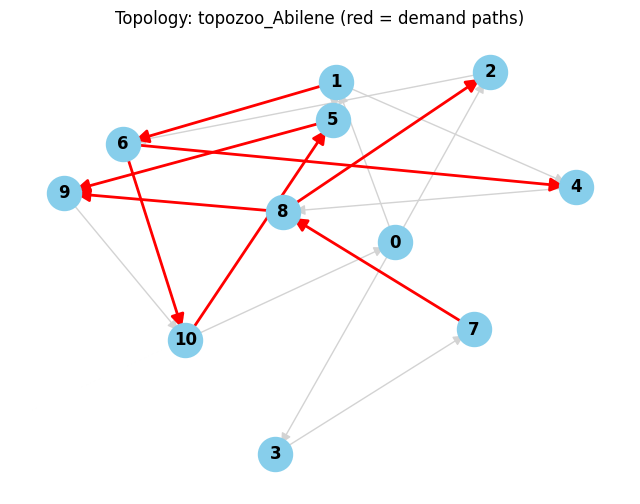

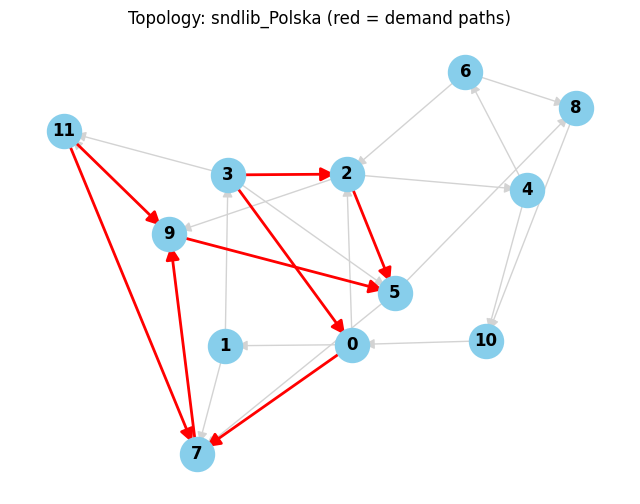

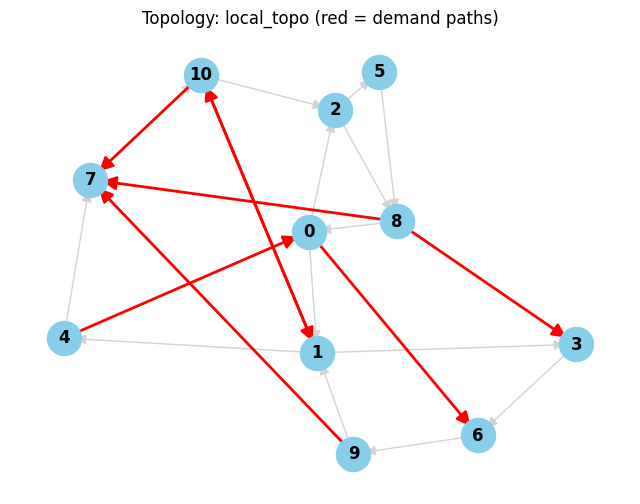

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Example: full physical edges of topologies
# (Replace with actual topology edges if you have them)
physical_edges_topozoo_Abilene = [
    (0,1),(0,2),(0,3),(1,4),(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,8),(8,9),(9,10),(10,0)
]
physical_edges_sndlib_Polska = [
    (0,1),(0,2),(1,3),(2,4),(3,5),(4,6),(5,7),(6,8),(7,9),(8,10),(9,11),(10,0),(1,7),(2,9),(3,11),(4,10),(5,8),(6,2)
]
physical_edges_local_topo = [
    (0,1),(0,2),(1,3),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(7,10),(8,0),(9,1),(10,2),(2,8)
]

# Demands (from your data)
demand_edges_topozoo_Abilene = [(6,10),(6,4),(8,2),(8,9),(10,5),(5,9),(7,8),(1,6)]
demand_edges_sndlib_Polska = [(11,7),(3,0),(7,9),(11,9),(3,2),(2,5),(0,7),(9,5)]
demand_edges_local_topo = [(8,3),(1,10),(10,7),(9,7),(0,6),(10,1),(4,0),(8,7)]

# Visualization function
def plot_topology(name, physical_edges, demand_edges):
    G = nx.DiGraph()
    G.add_edges_from(physical_edges)
    
    pos = nx.spring_layout(G, seed=42)  # consistent layout
    plt.figure(figsize=(8,6))
    
    # Draw all nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=600)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Draw all physical edges (light gray)
    nx.draw_networkx_edges(G, pos, edgelist=physical_edges, edge_color='lightgray', arrowsize=15)
    
    # Highlight demand edges (red)
    nx.draw_networkx_edges(G, pos, edgelist=demand_edges, edge_color='red', width=2, arrowsize=20)
    
    plt.title(f"Topology: {name} (red = demand paths)")
    plt.axis('off')
    plt.show()

# Plot all topologies
plot_topology("topozoo_Abilene", physical_edges_topozoo_Abilene, demand_edges_topozoo_Abilene)
plot_topology("sndlib_Polska", physical_edges_sndlib_Polska, demand_edges_sndlib_Polska)
plot_topology("local_topo", physical_edges_local_topo, demand_edges_local_topo)